In [576]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp
import pandas as pd
import math

%matplotlib inline

# Potential sub-surface channel
This notebook will contain the update as we step forward implementing the **Potential Sub-surface** acoustic variable inside **Ocean Navigator**.It is a boolean that indicates the potential existence of a sub-surface sound channel. 

>*A sub-surface sound channel can exist if there are two local minima in the sound speed profile above 1000 m.*

 If yes, The difference in sound speed between the local maxima and the first local minimum must be greater than 5 m/s.
       
 If two local minima exist but only one local maximum exists then
  - The local maximum cannot be higher in the water column than the first local minimum (is that check necessary - perhaps since the order in argrelextrema is so large)
   - The difference in the speed of sound at the surface and the first local minimum is greater than 5 m/s and the difference between the speed of sound at the local minimum and local maximum is greater than 5 m/s.

### Importing a sample profile

In [587]:
#profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T16_45_30.510267.csv", comment='/') 
profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-02-01T17 28 05.033836_POSITIVE.csv", header=2) 

In [588]:
profile.columns

Index(['Latitude', 'Longitude', 'Depth (m)', 'Pressure', 'Salinity',
       'Temperature', 'Sound Speed'],
      dtype='object')

In [589]:
profile_depth_sspeed = profile[['Sound Speed', 'Depth (m)']] # extracting only the soundspeed and depth column
profile_depth_sspeed = profile_depth_sspeed[profile_depth_sspeed ['Depth (m)'] < 1000] #taking only the rows where depth < 1000
profile_depth_sspeed


,Sound Speed,Depth (m)
0,1464.6,0.5
1,1464.6,1.5
2,1464.6,2.6
3,1464.6,3.8
4,1464.7,5.1
5,1464.7,6.4
6,1464.7,7.9
7,1464.8,9.6
8,1464.9,11.4
9,1465.1,13.5


Text(0.5, 0, 'Speed of sound [m/s]')

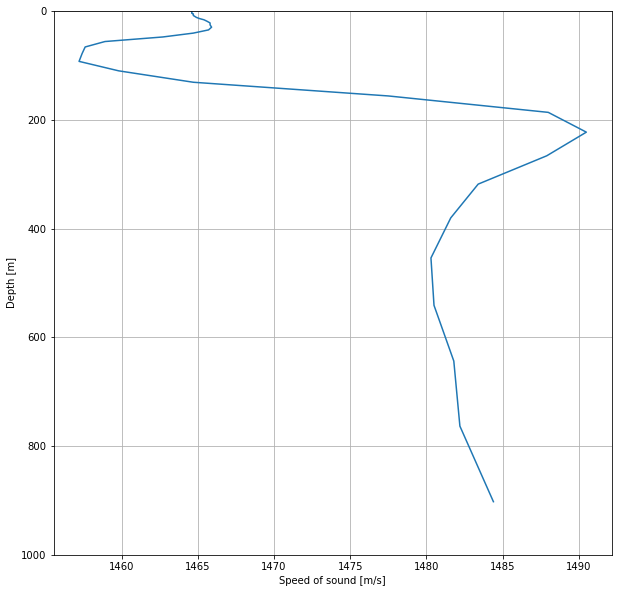

In [590]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')

Using the *find_peaks()* function from *scipy.signal* to detect the localminima

In [591]:
profile_np = np.array(profile_depth_sspeed['Sound Speed'])
local_minima = sp.find_peaks(-profile_np) # get the index array of local minima
local_minima =local_minima[0]
local_maxima = sp.find_peaks(profile_np) # get the index array of the local maxima
local_maxima = local_maxima[0]


Plotting the returned minima and maxima on the sound speed profile plot.

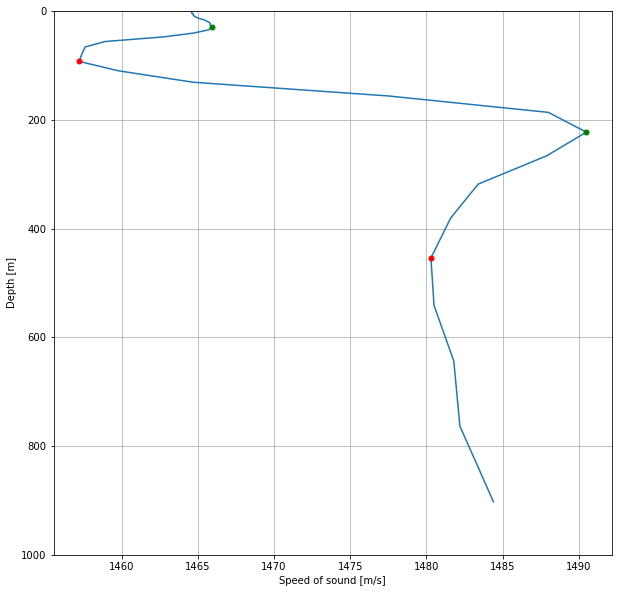

In [592]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile_depth_sspeed['Sound Speed'], profile_depth_sspeed['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(profile_depth_sspeed['Sound Speed'][local_minima],profile_depth_sspeed['Depth (m)'][local_minima],'r.',markersize=10)
ax.plot(profile_depth_sspeed['Sound Speed'][local_maxima],profile_depth_sspeed['Depth (m)'][local_maxima],'g.',markersize=10)

#### Checking if array *local_minima* has 2 or more minima
    - If yes, The difference in sound speed between the local maxima and the first local minimum must be greater than 5 m/s.
       
       If two local minima exist but only one local maximum exists then
   
            - The difference in the speed of sound at the surface and the first local minimum is greater than 5 m/s and the difference between the speed of sound at the local minimum and     local maximum is greater than 5 m/s.

Followed this file for reference.
https://github.com/DFO-Ocean-Navigator/Ocean-Data-Map-Project/blob/master/data/calculated_parser/functions.py

In [593]:
has_PSSC = 0

sound_speed = profile_depth_sspeed['Sound Speed']
depth = profile_depth_sspeed['Depth (m)']
if len(local_minima)>=2: #if there are 2 or more minima
    p1 = 0 # surface
    p2 = local_minima[0] #first minimum
    if len(local_maxima)>=2: # if there are more than one maxima
        p1 = local_maxima[0] #first maximum
        p3 = local_maxima[1] #second maximum
    else: #only one local maximum
        p3 =  local_maxima[0] 
        if p3 < p2: # the only one maxima is higher in the water column than the minima
            has_PSSC=0
    print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
    p1_sound_speed = sound_speed[p1]
    p2_sound_speed = sound_speed[p2]
    p3_sound_speed = sound_speed[p3]
    
    c1 = abs(p1_sound_speed-p2_sound_speed) 
    c2 = abs(p3_sound_speed-p2_sound_speed)
    print("c1 = "+ str(c1) +"m/s")
    print("c2 = "+ str(c2) +"m/s")
    
    if c1>5 and c2>5:
        has_PSSC =1
    else:
        has_PSSC =0
else:
    has_PSSC =0 

print("Value of Potential sub-surface channel :" + str(has_PSSC))

p1 p2 p3 : 14 21 26
c1 = 8.700000000000045m/s
c2 = 33.299999999999955m/s
Value of Potential sub-surface channel :1


Displaying the c1 and c2 in the plot

In [594]:
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

24.070100070373744


Text(0.375, 0.5, 'Angle between the gradient lines : 24 degrees')

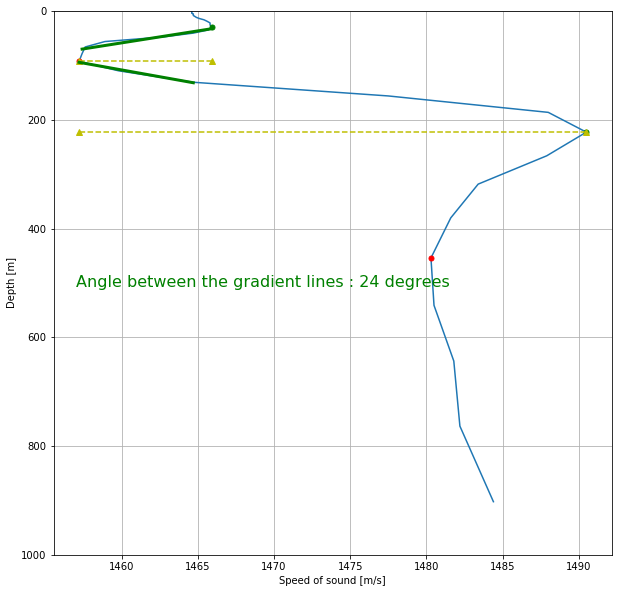

In [599]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(sound_speed,depth)
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(sound_speed[local_minima],depth[local_minima],'r.',markersize=10)
ax.plot(sound_speed[local_maxima],depth[local_maxima],'g.',markersize=10)
#plotting c1
x_p1p2 = [sound_speed[i] for i in [p1,p2]]
y_p1p2 = [depth[i] for i in [p2,p2]]
ax.plot(x_p1p2, y_p1p2, 'y^--',label= "c1")
#plotting c2
x_p3p2 = [sound_speed[i] for i in [p3,p2]]
y_p3p2 = [depth[i] for i in [p3,p3]]
ax.plot(x_p3p2, y_p3p2, 'y^--',label= "c2")

### A conceptal implementation of slope of profile below SLD

# poc code for the negative slope of profile below SLD
neg_gradient_x = pd.Series(sound_speed[p1:p2])
neg_gradient_y = pd.Series(depth[p1:p2])
slope1, intercept1 = np.polyfit(neg_gradient_x,neg_gradient_y,1)
ax.plot(neg_gradient_x, slope1*neg_gradient_x + intercept1, linewidth=3,color='green')
# poc code for the positive slope of profile below SLD
channel_end_depth = np.interp(sound_speed[p1], sound_speed, depth) #interpolating the depth, where the sound speed value will be equalt to Sound speed at SLD
channel_end_index = depth[p2:].sub(channel_end_depth).abs().idxmin()
pos_gradient_x = pd.Series(sound_speed[p2:channel_end_index+1])
pos_gradient_y = pd.Series(depth[p2:channel_end_index+1])
slope2, intercept2 = np.polyfit(pos_gradient_x,pos_gradient_y,1)
ax.plot(pos_gradient_x, slope2*pos_gradient_x + intercept2, linewidth=3,color='green')

# Calculate the angle between the two lines
temp = (slope2-slope1)/(1+(slope1*slope2))
angle = abs(math.degrees(math.atan(temp)))
print(angle)

ax.text(0.5*(right), 0.5*(bottom+top), 'Angle between the gradient lines : ' + str(round(angle)) +" degrees",
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, color='green',
        transform=ax.transAxes)

## Refactoring the steps inside a function
The steps to find the potential sub-surface channel is refactored in a function below. 

In [600]:
"""
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel(depth, sspeed)-> bool:
    has_PSSC = 0
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1>5 and c2>5:
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC

In [601]:
depth = profile['Depth (m)']
sspeed = profile['Sound Speed']
detect_potential_sub_surface_channel(depth, sspeed)

p1 p2 p3 : 14 21 26


1

## Next steps
Test this code using some profiles from Navigator
- ~~Refactor the code into a single method (what will be the inputs in that case?)~~
- ~~Find 5 profiles that will have a sub-surface channel (will return 1)~~
- ~~Find 5 profiles where sub-surface channel exists (will return 0)~~
- Verify that this algorithm works


### Modification Planned to integrate frequency cutoff 
The previously stated definition of sub-surface channel used a constant value 5 m/s to compare the distance between the maxima and the minima. That 5 m/s value is 	&#916;C in the following image, which is the difference between **first minima** and **first maxima**.

![Sound Channel](images/SoundChannel.jpg)

(On the above image when mentioning the Channel width it is shown as &#916;C, but it will be &#916;Z )

From the above image and the following equation, it can be seen that, &#916;C is dependent on C<sub>min</sub> (Local Minima on the first negative gradient), &#916;Z (Channel Width) which can be calculated from the sound profile. And we have to use a fixed value of f<sub>cutoff</sub> when we calculate &#916;C. **This value of f<sub>cutoff</sub>  will indicate the minimum frequency of sound that will be trapped in that sub-surface sound channel**

![Frequency cut off Equation](images/eqn.jpg)





#### Question 
- Are we intending to calculate the &#916;C considering a fixed value of f<sub>cutoff</sub>, which indicates that, the navigator will detect a sound channel which will allow to pass/trap sound of a minimum frequency of pre-determined f<sub>cutoff</sub>.

- Or another approach can be, user can select or input a value for f<sub>cutoff</sub> from *Navigator* UI and then we will calculate the &#916;C from that selected f<sub>cutoff</sub>. This approach will provide the user a way to check, if a sub-surface channel exists for a specific minimum frequency of sound. 



#### Calculating the ΔC
We are making a function so that we can calculate the ΔC from a given sound-profile and a value for f<sub>cutoff</sub>

\begin{align*}
\Delta C = \frac{C_{min}}{\big(\frac{f_{cutoff} \times \Delta Z}{0.2652   \times   C_{min}}\big)^{2}}
\end{align*}

In [486]:
"""
     Calculate ΔC from a given sound profile and freq cutoff
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns the value of ΔC, which will later be used inside the 
"""
def calculate_del_C(depth, sspeed, freq_cutoff):
    # Getting Cmin from the sound speed profile
    first_local_minimum = sp.find_peaks(-sspeed)[0][0]
    Cmin = sspeed[first_local_minimum]
    #Calculating del_Z
    local_maximum = sp.find_peaks(sspeed)[0][0]
    channel_start_depth = depth[local_maximum]
    channel_end_depth = np.interp(sspeed[local_maximum], sspeed, depth) 
    del_Z = channel_end_depth - channel_start_depth
    # print(channel_start_depth)
    # Final calculation of delC
    numerator = freq_cutoff * del_Z
    denominator = 0.2652 * Cmin
    final_denom = numerator/denominator
    final_denom =np.power(final_denom,2)
    delC = float(Cmin/final_denom)
    return delC
    

In [487]:
f_cutoff = 2755.031856
calculate_del_C(depth,sspeed, f_cutoff)

0.006489289007673262

### Integrating this *calculate_del_C()* function inside the *detect_potential_sub_surface_channel()* function
So, as we have implemented a way to calculate the value of ΔC from a given sound profile and a given value of f<sub>cutoff</sub>. This function will be used on our previously implemented sub-surface detection function. 
- First implementation will take a frequency cutoff input, and will calculate ΔC for that specific freq_cutoff value (v2)
- Second implementation will not take any frequency cutoff input. Rather it will calculate the ΔC for a pre-defined frequency cutoff (For this example we will use freq_cutoff value of 2755.031856 Hz) (v3)

#### Implementation v2
This implementation will take $f_{cutoff}$ as input, which will provide the user a way to select a value of $f_{cutoff}$ that the user might be interested in. We will use this one, if the user wants to select a minimum value for frequency cutoff on the Navigator UI. For example, if the ask is, **I want to check if a certain location contains a sub-surface channel that can trap sound that is greater than a given amount of frequency**

In [496]:
"""
     Implementaion #2
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel_v2(depth, sspeed, freq_cutoff)-> bool:
    has_PSSC = 0
    del_C = calculate_del_C(depth, sspeed, freq_cutoff)
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        # print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1> del_C and c2> del_C: # Changing this comparison to check with the calculated ΔC
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC

We will set a *frequency cutoff* of 2755.03 to test the *detect_potential_sub_surface_channel_v2()* function.

In [489]:
f_cutoff = 2755.03
depth = profile['Depth (m)']
sspeed = profile['Sound Speed']
detect_potential_sub_surface_channel_v2(depth, sspeed, f_cutoff)

1

#### Implementation v3
It is an alternative to the previous v2 approach which will consider a fixed $f_{cutoff}$, **won't take it as in input to the algorithm** , and calculate $\Delta C$ considering that pre-determined value. This implementation will be used, if we decide to agree on a fixed value of frequency cutoff. That is, let's say if the ask is, **I want to check if this certain location can have sub-surface channel, which will trap sound of frequency greater than a fixed value(for example 2755.03, or any predetermined value)**

In [497]:
"""
     Implementaion #3
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel_v3(depth, sspeed)-> bool:
    has_PSSC = 0
    del_C = calculate_del_C(depth, sspeed, 2755.03)
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        # print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1> del_C and c2> del_C: # Changing this comparison to check with the calculated ΔC
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC

In [498]:
depth = profile['Depth (m)']
sspeed = profile['Sound Speed']
detect_potential_sub_surface_channel_v3(depth, sspeed)

1

## Running the algorithms on an example sound speed profile
We will then try to pass a sound-profile to the implemented algorithms. This is the sound profile that was send as an example to have a sub-surface channel(Secondary sound channel as suggested by Adam). This should yield a **1**, if passed to our sub-surface channel detection algorithm. 

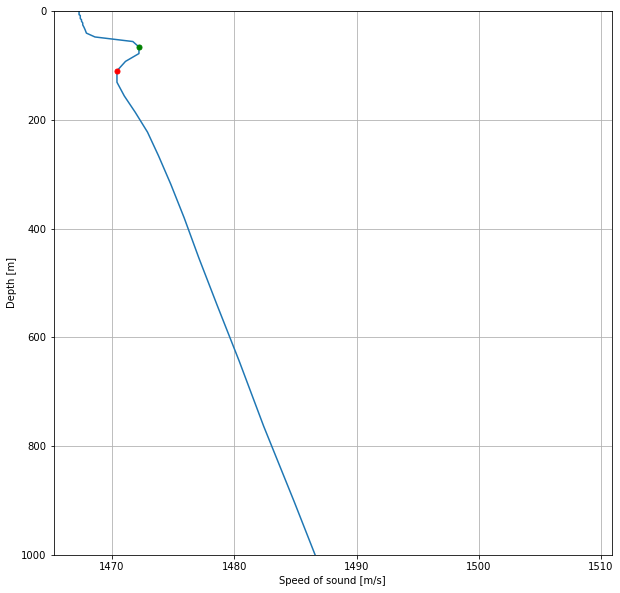

In [504]:
## reading the sound speed profile
sound_speed_profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-02-01T16 14 10.909373_require_feedback.csv", header=2)
depth = sound_speed_profile['Depth (m)']
sspeed = sound_speed_profile['Sound Speed']
# finding minima and maxima in the profile
profile_np = np.array(sound_speed_profile['Sound Speed'])
local_minima = sp.find_peaks(-profile_np) # get the index array of local minima
local_minima =local_minima[0]
local_maxima = sp.find_peaks(profile_np) # get the index array of the local maxima
local_maxima = local_maxima[0]
# plotting the profile
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(sound_speed_profile['Sound Speed'], sound_speed_profile['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')
ax.plot(sound_speed_profile['Sound Speed'][local_minima],sound_speed_profile['Depth (m)'][local_minima],'r.',markersize=10)
ax.plot(sound_speed_profile['Sound Speed'][local_maxima],sound_speed_profile['Depth (m)'][local_maxima],'g.',markersize=10)

#### Passing the profile to detect_potential_sub_surface_channel (version 1)
We will pass the sound speed profile to the first version of implementation, which is written following the previously stated definition of [**Potential sub-surface sound channel**](#-potential-sub-surface-channel) (Without considering the frequency cutoff)


In [503]:
detect_potential_sub_surface_channel(depth, sspeed)

0

This returns a 0, which indicates there are no possible sound-channel according to the provided definition, where as per DND's feedback, this sound-profile should have yield 1, that means, should have a sub-surface channel.

#### Passing the profile to detect_potential_sub_surface_channel_v2 (version 2)
We will now pass the sound speed profile to the second version of implementation, which is constructed following the feedback from Adam, and we tried to integrate the frequency cutoff value for calculating the $\Delta C$. And we are trying to find out if a sound channel exists for a minimum frequency of  2755.03 Hz, 1561.1 Hz


In [505]:
detect_potential_sub_surface_channel_v2(depth, sspeed, 2755.03)

0

In [506]:
detect_potential_sub_surface_channel_v2(depth, sspeed, 1561.1)

0

For both value of minimum sound frequency/frequency cutoff, implementation version 2 is showing a result 0 which should be a 1.

#### Passing the profile to detect_potential_sub_surface_channel_v3 (version 3)
We will now pass the sound speed profile to the second version of implementation, which is also constructed following the feedback from Adam, and we tried to integrate the frequency cutoff value for calculating the $\Delta C$. And we are trying to find out if a sound channel exists for a minimum frequency of 2755.03 Hz. (This is fixed and can not be passed in implementation version 3)


In [507]:
detect_potential_sub_surface_channel_v3(depth, sspeed)

0

### Issue regarding the implementations
In all of the implementations we have assumed that, to have a sub-surface channel, a sound profile must have two local minima. But, the sound profile that is provided by the DND, clearly has only one minima on the plot. That's why it is not satisfying the primary condition of having two minima, thus not detecting a sub-surface channel. 

#### Questions
1. We need more clarification on the condition of having two minima before 1000m in the definition of sub-surface channel. Do we check for two local minima? or a sub-surface channel can occur if even there are one local minimum on the sound speed profile before 1000m depth (As the previous sound speed profile)
2. Do we use the fixed Δ𝐶 value of 5 m/s, or we calculate it for a minimum frequency cutoff? 
3. If we decide to consider a frequency cutoff to calculate that Δ𝐶, we use the implementation version 2 or version 3? (That is, if we use version 2, it will be possible to provide a value for frequency cutoff from Navigator UI, or if we use version 3, we agree on a fixed value of frequency cutoff)

### An alternative implementation 
We will now try to write up an alternative implementation, which considers there can be a sub-surface channel if even there's only one local minima in the sound speed channel. We will try to integrate the concept of frequency cutoff in this new version of implementation. We will

In [ ]:
"""
     Implementaion #4
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel_v3(depth, sspeed, freq_cutoff)-> bool:
    has_PSSC = 0
    del_C = calculate_del_C(depth, sspeed, freq_cutoff)
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        # print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1> del_C and c2> del_C: # Changing this comparison to check with the calculated ΔC
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC